In [38]:
# just some useful functions, imports and settings

import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit

from datetime import datetime
def time_string():
    # return datetime.now().strftime("%d %B %Y %X")
    return datetime.now().strftime("%X")
impath = 'trash_img'    # путь к папке, в которой будут сохраняться картинки
#switching latex fonts
plt.rcParams.update({
    "text.usetex" : True,
    "font.family" : "serif",
    "font.serif" : "Computer Modern",
    "text.latex.preamble" : r'\usepackage{amsmath} \usepackage{mathtext} \usepackage[english, russian]{babel}',
    "axes.grid": True,
    "axes.grid.which": 'both',
    'grid.linewidth': '1',
})
plt.rcParams.update({
    "figure.figsize": (8, 6),
    'figure.dpi': 200
})

# необходимые функции

def err_pres_formatter(value, error):
    """Rounds value and it's error according to scientific conventions"""
    first_digit = (np.array(error/10**np.floor(np.log10(error)), dtype="int"))
    first_digit_position = np.array(np.floor(np.log10(error)), dtype="int")
    ndigits = 1
    if first_digit == 1:
        ndigits += 1
    power = np.log10(abs(value))
    if abs(power//3) >= 1:
        power = 3*int(power//3)
        value /= 10**power
        error /= 10**power
        digit_number = -first_digit_position + ndigits+power-1
        if digit_number <= 0:
            return f"({round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)})$\cdot 10^{{{power}}}$"
        return f"({round(value, digit_number)} \u00B1 {round(error, digit_number)})$\cdot 10^{{{power}}}$"
    digit_number = -first_digit_position + ndigits-1
    if digit_number <= 0:
        return f"{round(int(value), digit_number)} \u00B1 {round(int(error), digit_number)}"
    return f"{round(value, digit_number)} \u00B1 {round(error, digit_number)}"


def lower_upper_limits(domain, fun, popt, pcov, nsigma=1):
    '''Вычисляет минимальные и максимальные значения функции 
    при заданных парамерах и стандартных отклонениях
    в пределах nsigma*стандартное отклонение
    Возвращает:
    minA :(np.array) - массив минимальных значений
    maxA :(np.array) - массив максимальных значений'''
    err = np.sqrt(np.diag(pcov))
    corr = pcov /np.expand_dims(err, 1) / np.expand_dims(err, 0)
    deviations = np.eye(popt.size)*np.expand_dims(err, 1)  
    df = np.expand_dims(fun(domain, *popt), 1) - fun(np.expand_dims(domain, 1), *(np.expand_dims(popt, 1)+np.eye(popt.size)*np.expand_dims(err, 1)))
    dfmatrixes = np.expand_dims(df, 1)*np.expand_dims(df, 2) * np.expand_dims(corr, 0)
    sigm_f = np.sqrt(np.sum(dfmatrixes, axis=(1, 2)))
    return (fun(domain, *popt)-nsigma*sigm_f, fun(domain, *popt)+nsigma*sigm_f)

def plot_approx(x, y, f, par_names_str, fun_name, yerr=None, visApproxError=True, p0=None):
    if yerr is not None:
        popt, pcov = curve_fit(f, x, y, sigma=yerr, absolute_sigma=True, p0=p0)
    else:
        popt, pcov = curve_fit(f, x, y, p0=p0)
    err = np.sqrt(np.diag(pcov))
    for v, er in zip(popt, err):
        print(v,'+-',er)
    approx_label = f"approximation of function {fun_name}"
    if (err == np.inf).any():
        print('Аппроксимация не сошлась. Попробуй задать начальные параметры p0')
    else:
        par_names = [x.split(',') for x in par_names_str.strip().split("\n") if (len(x) != 0)]
        for i in range(len(par_names)):
            t = par_names[i]
            if len(t) == 2:
                name, units = t
            else:
                name, units = *t, ''
            approx_label += f"\n{name} = {err_pres_formatter(popt[i], 2*err[i])} {units}"
    teorPoints = 50     
    intent = 0.0   # отступ по бокам от обласи экспериментальных данных
    a, b = x.min(), x.max()
    X = np.linspace(a-(b-a)*intent, b+(b-a)*intent, num=teorPoints)
    plt.plot(X, f(X, *popt), 'r', label=approx_label)
    if visApproxError and (pcov != np.inf).all():
        nsigma = 2
        minA, maxA = lower_upper_limits(X, f, popt, pcov, nsigma=nsigma)
        plt.fill_between(X, minA, maxA, alpha=0.4, label=f"область {nsigma} $\sigma$ ошибки")

def make_beautiful_plot(xname, xunit, yname, yunit):
    plt.grid(True, which='minor', linewidth=0.2)
    plt.grid(True, which='major')
    plt.xlabel(fr"{xname}, {xunit}")
    plt.ylabel(fr"{yname}, {yunit}")
    plt.title(fr"{yname}({xname})")
    plt.legend()

## 7a. Estimate $\pi$ using simple sampling Monte Carlo

In [4]:
def count_pi_randomly(N):
    x = np.random.random(N)
    y = np.random.random(N)
    frac = np.mean(x**2+y**2<1)
    pi = 4*frac
    return pi

-0.5138338008333835 +- 0.08479240628918229
0.39762780883152665 +- 0.7150545173645493


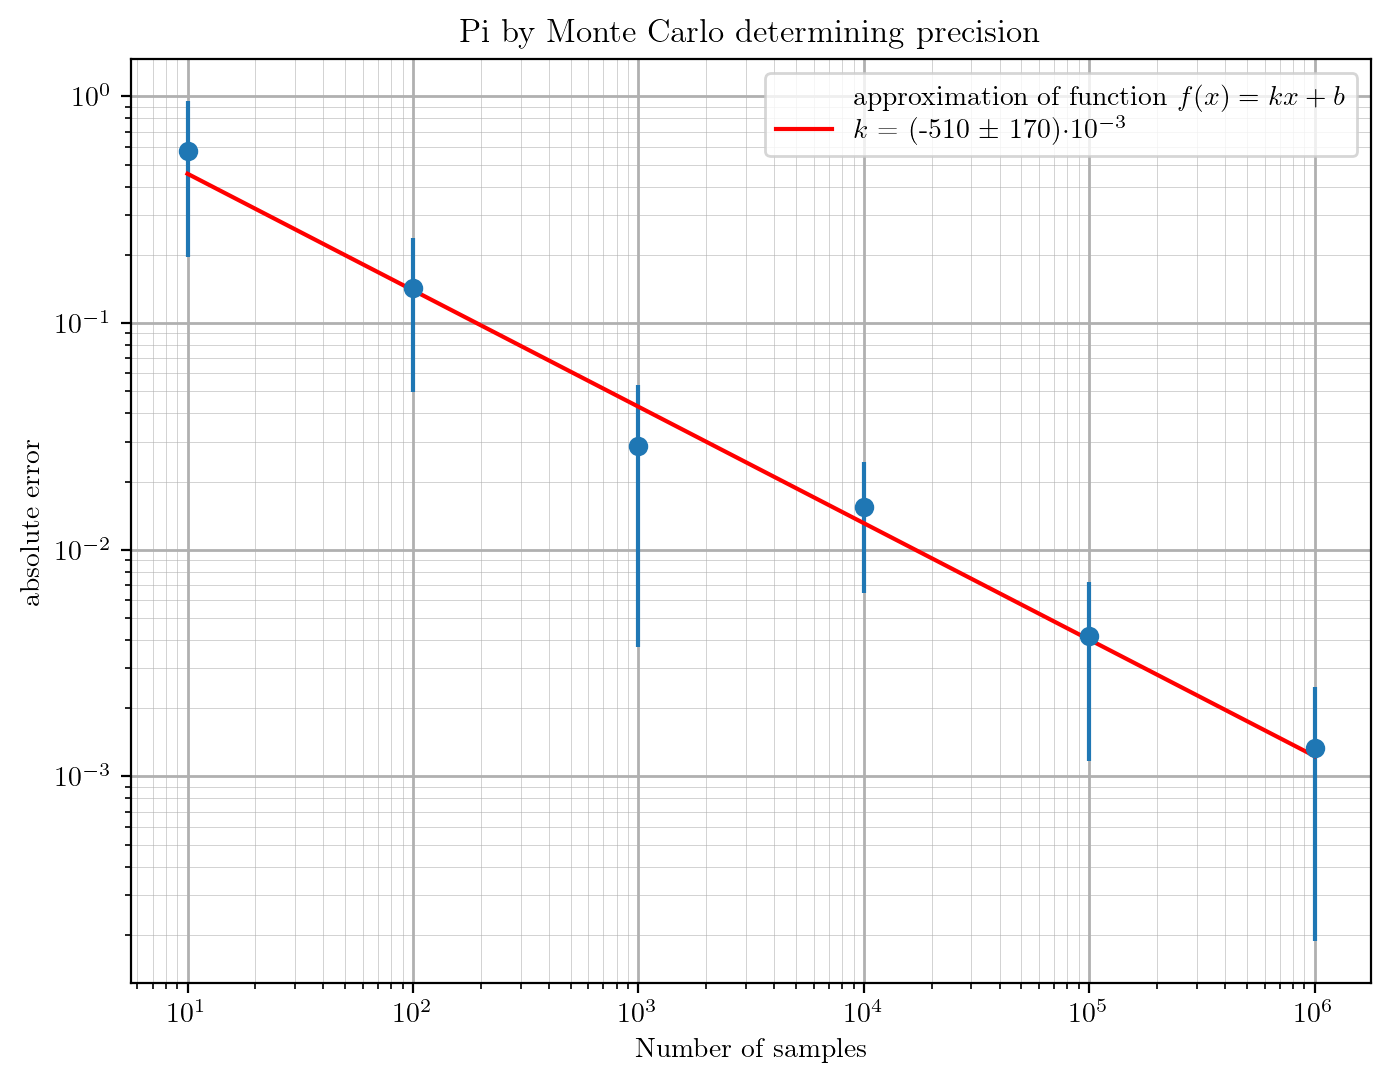

Best estimate is 3.14202


In [76]:
repeats = 20
Ns = np.array([10**i for i in range(1, 7)])
pis = np.array([[count_pi_randomly(N) for N in Ns] for _ in range(repeats)])

errors = np.abs(pis - np.pi)
avg_errors = np.mean(errors, axis=0)
er_error = np.sqrt(np.mean(np.square(errors - avg_errors), axis=0))

plt.errorbar(Ns, avg_errors, yerr=er_error, fmt='o')
plt.xscale('log')
plt.yscale('log')

plt.grid(True, which='minor', linewidth=0.2)
plt.grid(True, which='major')

plt.ylabel("absolute error")
plt.xlabel("Number of samples")
plt.title("Pi by Monte Carlo determining precision")



# function to approximate
fun_name = r"$f(x) = kx + b$"
def f(x, k, b):
    return np.exp(b + k * np.log(x))
par_names_str = fr'''
$k$, 
'''

plot_approx(Ns, avg_errors, f, par_names_str, fun_name, yerr=er_error, visApproxError=False)
plt.legend()
plt.show()
print("Best estimate is", pis[0, -1])

Slope of error function in log-log scale, as expected, is approximately -0.5

With $10^6$ samples precision is about $10^{-3}$

Best estimate is $\pi \approx 3.1420$

## 7b. Midpoint integration 

In [53]:
def integrate(func, H, xlims, ylims, Nx:int, Ny:int):
    """compute Simpson integration in 2d

    Args:
        func : integrated function
        H: indicator function of integrating region.
        xlims ([float, float])
        ylims ([float, float])
        """
    dx = np.abs(xlims[1]-xlims[0])/Nx
    dy = np.abs(ylims[1]-ylims[0])/Ny
    
    x = np.linspace(*xlims, Nx, endpoint=False) + dx/2
    y = np.linspace(*ylims, Ny, endpoint=False) + dy/2
    
    X, Y = np.meshgrid(x, y)
    int_sum = np.sum(H(X, Y)*func(X, Y))*dx*dy
    return int_sum
    

In [79]:
f = lambda x, y: np.ones_like(x)    # function is always 1, only area limits circle
def H(x, y):
    return x**2+y**2<1
integrate(f, H, [-1, 1], [-1, 1], 10, 10)


3.2

In [71]:
Ns = np.array([2**i for i in range(1, 6)])*10
pis = np.array([integrate(f, H, [-1, 1], [-1, 1], N, N) for N in Ns])

error = np.abs(pis-np.pi)

pis

array([3.16      , 3.16      , 3.14      , 3.141875  , 3.14265625])

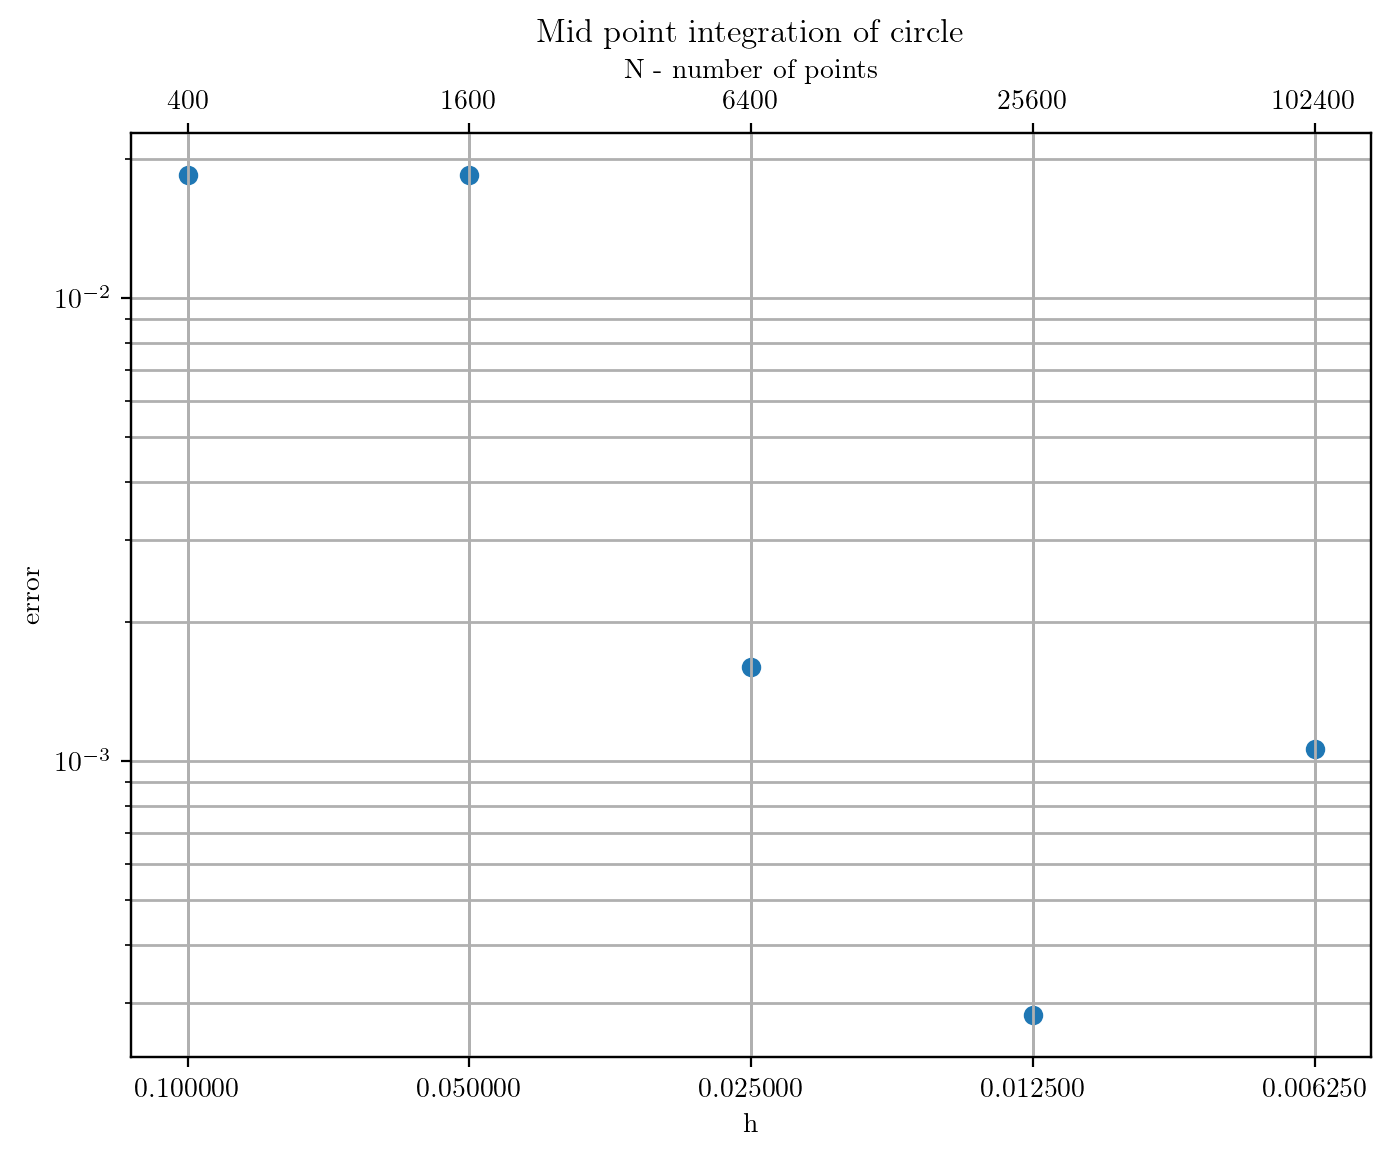

In [74]:

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
x = np.arange(len(Ns))
ax1.plot(x, error, 'o')
plt.title("Mid point integration of circle")
ax1.set_yscale("log")
ax1.set_ylabel("error")

hs = 2/Ns
ax1.set_xticks(x)
ax1.set_xlabel("h")
ax1.set_xticklabels([f"{x:f}" for x in hs])

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(x)
ax2.set_xlabel("N - number of points")
ax2.set_xticklabels([x**2 for x in Ns])
None

With $10^5$ points integration error is approximately $10^{-3}$

Last value is $\pi \approx 3.1426$

Monte Carlo need 10 times more computations for the same precision. 

### Same midpoint plot with more points

In [82]:
Ns = np.array([2**i for i in range(1, 8)])*10
pis = np.array([integrate(f, H, [-1, 1], [-1, 1], N, N) for N in Ns])
error = np.abs(pis-np.pi)


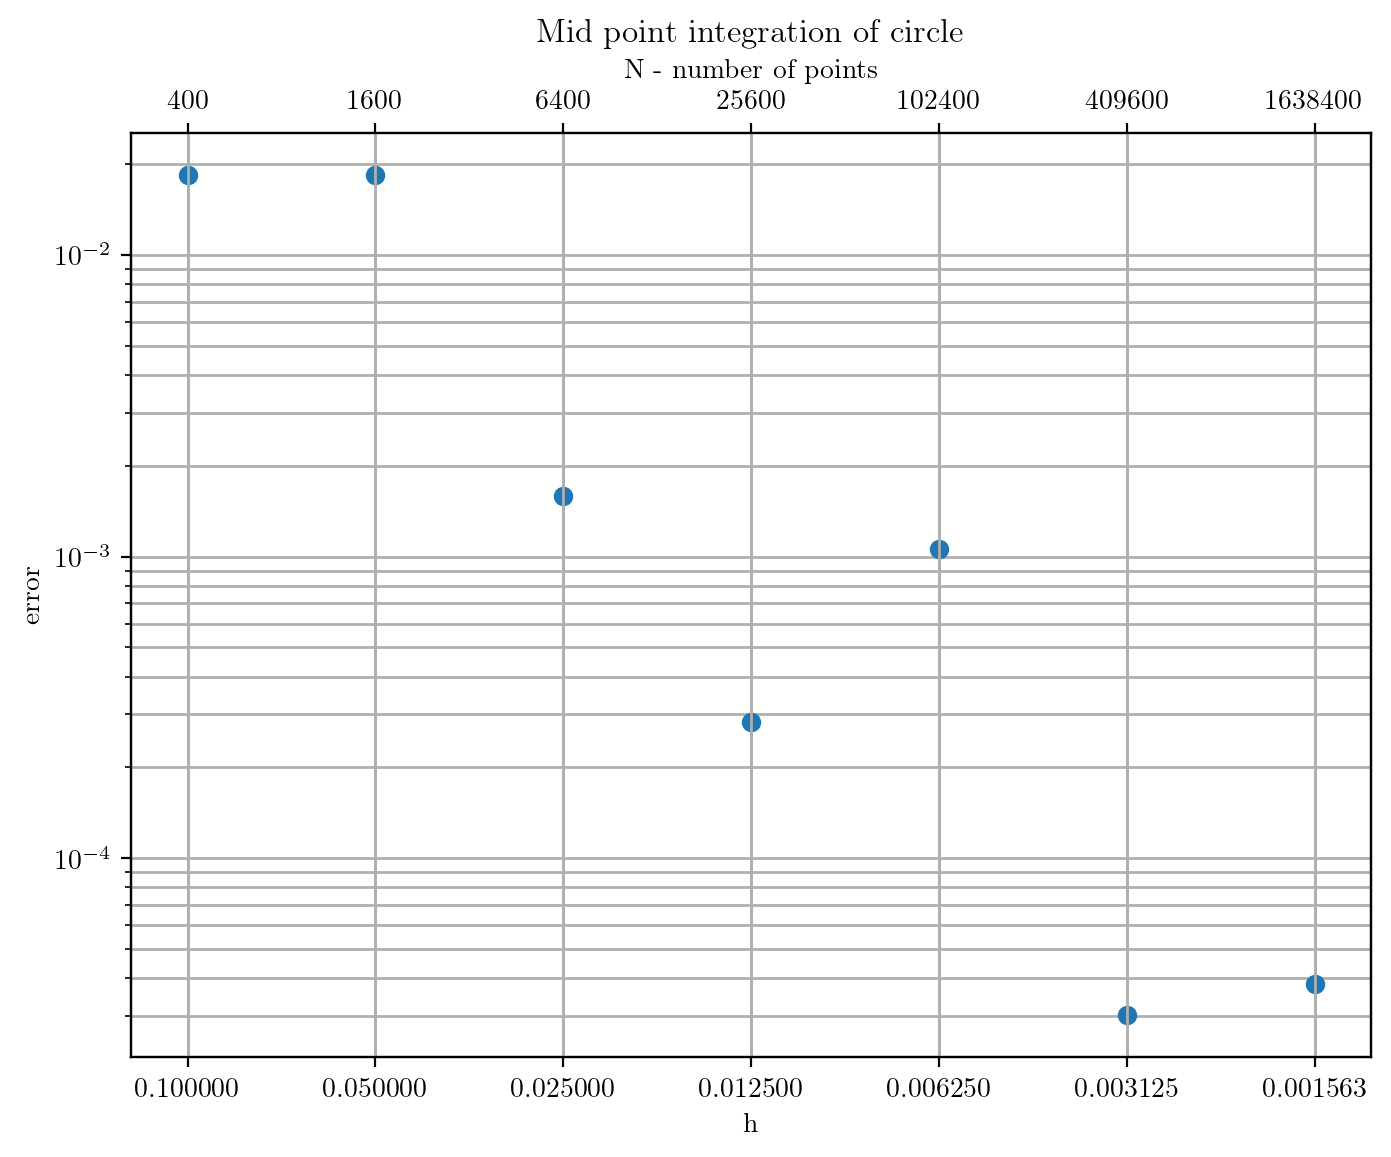

In [81]:

fig = plt.figure()
ax1 = fig.add_subplot(111)
ax2 = ax1.twiny()
x = np.arange(len(Ns))
ax1.plot(x, error, 'o')
plt.title("Mid point integration of circle")
ax1.set_yscale("log")
ax1.set_ylabel("error")

hs = 2/Ns
ax1.set_xticks(x)
ax1.set_xlabel("h")
ax1.set_xticklabels([f"{x:f}" for x in hs])

ax2.set_xlim(ax1.get_xlim())
ax2.set_xticks(x)
ax2.set_xlabel("N - number of points")
ax2.set_xticklabels([x**2 for x in Ns])
None